In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import numpy as np
import time
import os

## Helper Functions

In [ ]:
def get_patches(image):
    '''This functions creates and return patches of given image with a specified patch_size'''
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    height, width , channels= image.shape
    crop_sizes=[1]
    patch_size=40
    patches = []
    for crop_size in crop_sizes: #We will crop the image to different sizes
        crop_h, crop_w = int(height*crop_size),int(width*crop_size)
        image_scaled = cv2.resize(image, (crop_w,crop_h), interpolation=cv2.INTER_CUBIC)
        for i in range(0, crop_h-patch_size+1, int(patch_size/1)):
            for j in range(0, crop_w-patch_size+1, int(patch_size/1)):
              x = image_scaled[i:i+patch_size, j:j+patch_size] # This gets the patch from the original image with size patch_size x patch_size
              patches.append(x)
    return patches



def create_image_from_patches(patches,image_shape):
  '''This function takes the patches of images and reconstructs the image'''
  image=np.zeros(image_shape) # Create a image with all zeros with desired image shape
  patch_size=patches.shape[1]
  p=0
  for i in range(0,image.shape[0]-patch_size+1,int(patch_size/1)):
    for j in range(0,image.shape[1]-patch_size+1,int(patch_size/1)):
      image[i:i+patch_size,j:j+patch_size]=patches[p] # Assigning values of pixels from patches to image
      p+=1
  return np.array(image)

def get_image(gt,noise_level):
  '''This function takes a image and adds noise with specified level and return  noisy image and its patches'''
  patches=get_patches(gt)
  height, width , channels= gt.shape
  test_image=cv2.resize(gt, (width//40*40,height//40*40), interpolation=cv2.INTER_CUBIC)
  patches=np.array(patches)
  ground_truth=create_image_from_patches(patches,test_image.shape)

  #predicting the output on the patches of test image
  patches = patches.astype('float32') /255.
  patches_noisy = patches+ tf.random.normal(shape=patches.shape,mean=0,stddev=noise_level/255) 
  patches_noisy = tf.clip_by_value(patches_noisy, clip_value_min=0., clip_value_max=1.)
  noisy_image=create_image_from_patches(patches_noisy,test_image.shape)
  
  return ground_truth/255.,noisy_image,patches_noisy

In [55]:
def predict_fun(model,patches_noisy,gt):

  '''This  function takes noisy patches and original model as input and returns denoised image'''
  height, width , channels= gt.shape
  gt=cv2.resize(gt, (width//40*40,height//40*40), interpolation=cv2.INTER_CUBIC)
  denoised_patches=model.predict(patches_noisy)
  denoised_patches=tf.clip_by_value(denoised_patches, clip_value_min=0., clip_value_max=1.)

  #Creating entire denoised image from denoised patches
  denoised_image=create_image_from_patches(denoised_patches,gt.shape)

  return denoised_image
  

def predict_fun_tflite(model,patches_noisy,gt):
  '''This  function takes noisy patches and quantized model as input and returns denoised image'''
  height, width , channels= gt.shape
  gt=cv2.resize(gt, (width//40*40,height//40*40), interpolation=cv2.INTER_CUBIC)
  
  denoised_patches=[]
  for p in patches_noisy:
    model.set_tensor(model.get_input_details()[0]['index'],tf.expand_dims(p,axis=0))
    model.invoke()
    pred=model.get_tensor(model.get_output_details()[0]['index'])
    pred=tf.squeeze(pred,axis=0)
    denoised_patches.append(pred)
  
  denoised_patches=np.array(denoised_patches)
  denoised_patches=tf.clip_by_value(denoised_patches, clip_value_min=0., clip_value_max=1.)

  #Creating entire denoised image from denoised patches
  denoised_image=create_image_from_patches(denoised_patches,gt.shape)

  return denoised_image  
  
def PSNR(gt, image, max_value=1):
    """"Function to calculate peak signal-to-noise ratio (PSNR) between two images."""
    height, width , channels= gt.shape
    gt=cv2.resize(gt, (width//40*40,height//40*40), interpolation=cv2.INTER_CUBIC)
    mse = np.mean((gt - image) ** 2)
    if mse == 0:
        return 100
    return 20 * np.log10(max_value / (np.sqrt(mse)))

def plot_predictions(ground_truth,noisy_image,denoised_image,denoised_image_lite):
  '''This function is used for plotting predictions'''
  fig, axs = plt.subplots(2,2,figsize=(10,10))
  axs[0][0].imshow(ground_truth)
  axs[0][0].title.set_text('Ground Truth')
  axs[0][1].imshow(noisy_image)
  axs[0][1].title.set_text('Noisy Image')
  axs[1][0].imshow(denoised_image)
  axs[1][0].title.set_text('Denoised Image using original model')
  axs[1][1].imshow(denoised_image_lite)
  axs[1][1].title.set_text('Denoised Image using quantized model')
  fig.tight_layout()
  plt.show()

In [4]:
#Loading the original model
dncnn=tf.keras.models.load_model('dncnn.h5')

#Loading the quantized model
dncnn_lite = tf.lite.Interpreter(f'dncnn.tflite')
dncnn_lite.allocate_tensors()

In [51]:
def final(imagefile,noise_level):

  '''This function takes image path and noise level and does all the steps from input to getting predictions'''
  gt=cv2.imread(imagefile)
  ground_truth,noisy_image,patches_noisy=get_image(gt,noise_level=noise_level)
  start=time.time()
  denoised_image=predict_fun(dncnn,patches_noisy,gt)
  end=time.time()
  time_taken=end-start
  print('PSNR of noisy image :',PSNR(ground_truth,noisy_image))
  print('PSNR of denoised image using original model: %.3f db , Time taken : %.5f seconds'%(PSNR(ground_truth,denoised_image),time_taken))

  start=time.time()
  denoised_image_lite=predict_fun_tflite(dncnn_lite,patches_noisy,gt)
  end=time.time()
  time_taken=end-start
  print('PSNR of denoised image using original model: %.3f db , Time taken : %.5f seconds'%(PSNR(ground_truth,denoised_image_lite),time_taken))

  plot_predictions(ground_truth,noisy_image,denoised_image,denoised_image_lite)

  return denoised_image,denoised_image_lite

PSNR of noisy image : 18.8937582330146
PSNR of denoised image using original model: 27.914 db , Time taken : 0.09188 seconds
PSNR of denoised image using original model: 27.914 db , Time taken : 2.94448 seconds


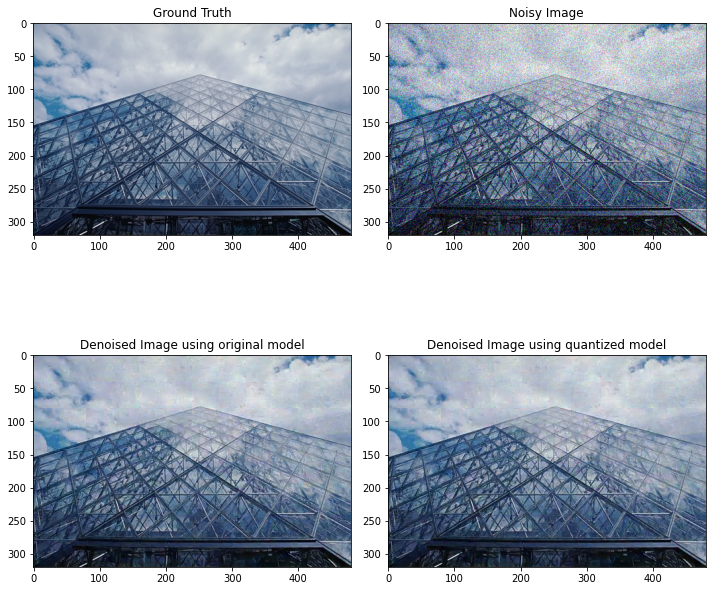

In [57]:
denoised_image,denoised_image_lite=final('223061.jpg',30)

PSNR of noisy image : 15.55138561502261
PSNR of denoised image using original model: 22.308 db , Time taken : 0.09437 seconds
PSNR of denoised image using original model: 22.308 db , Time taken : 2.92970 seconds


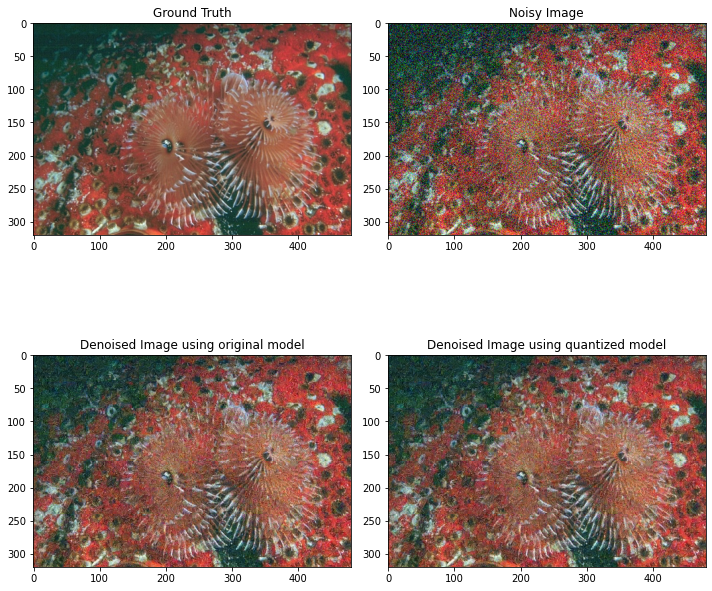

In [56]:
denoised_image,denoised_image_lite=final('12084.jpg',45)

PSNR of noisy image : 18.616657019712058
PSNR of denoised image using original model: 31.548 db , Time taken : 0.09020 seconds
PSNR of denoised image using original model: 31.548 db , Time taken : 2.95333 seconds


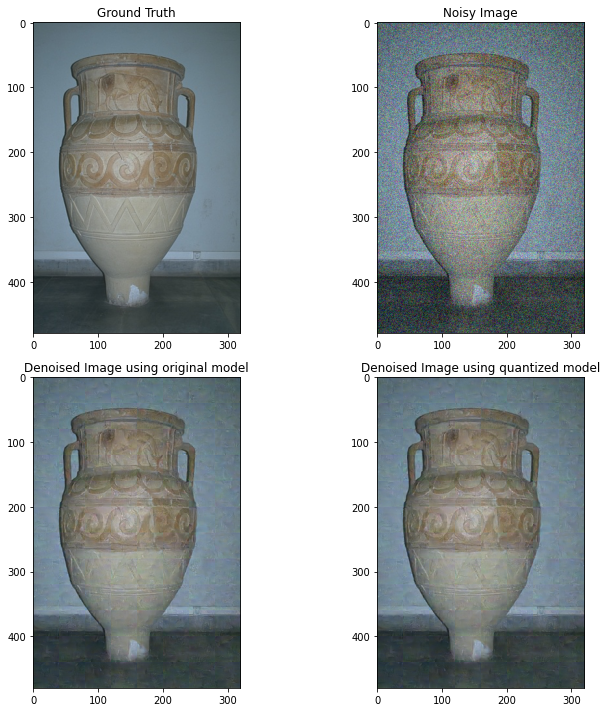

In [59]:
denoised_image,denoised_image_lite=final('227092.jpg',30)

PSNR of noisy image : 17.560405812513448
PSNR of denoised image using original model: 26.664 db , Time taken : 0.09034 seconds
PSNR of denoised image using original model: 26.664 db , Time taken : 3.04348 seconds


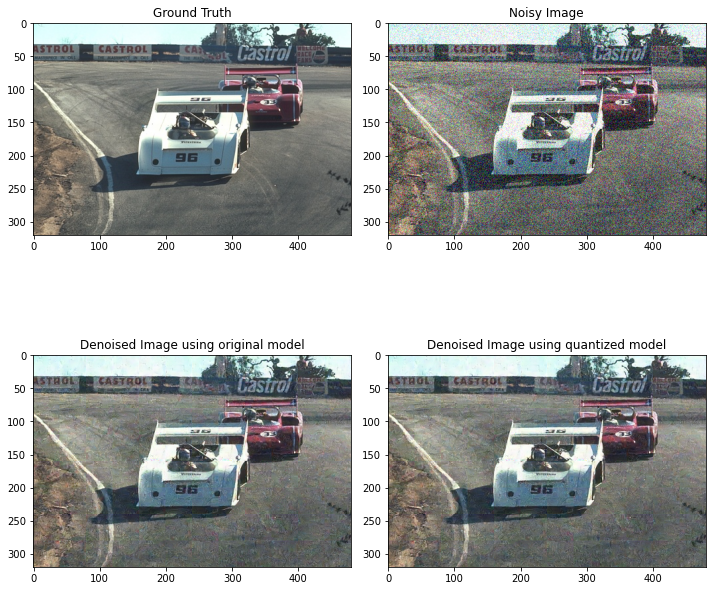

In [61]:
denoised_image,denoised_image_lite=final('21077.jpg',35)

PSNR of noisy image : 17.541863695670664
PSNR of denoised image using original model: 27.162 db , Time taken : 0.09059 seconds
PSNR of denoised image using original model: 27.162 db , Time taken : 2.97637 seconds


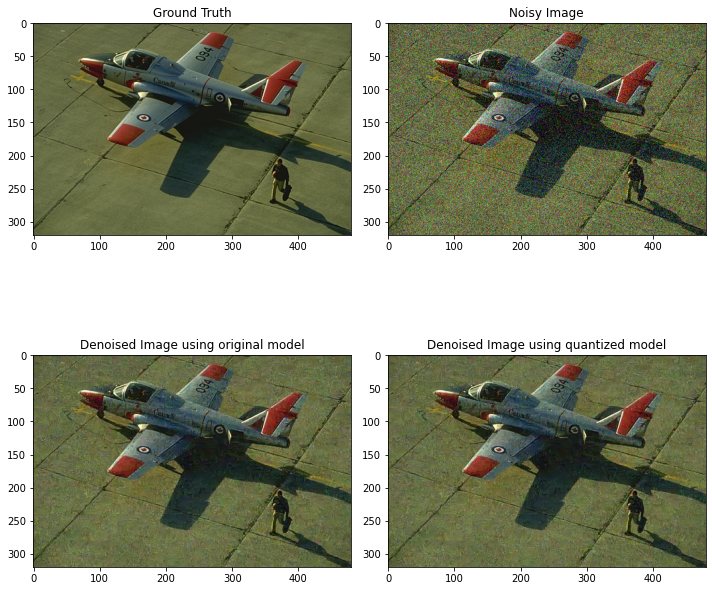

In [62]:
denoised_image,denoised_image_lite=final('37073.jpg',35)

In [63]:
file_name = "dncnn.h5"
file_stats = os.stat(file_name)
print(f'File Size of original model in MegaBytes is {file_stats.st_size / (1024 * 1024)}')

File Size of original model in MegaBytes is 7.588813781738281


In [64]:
file_name = "dncnn.tflite"
file_stats = os.stat(file_name)
print(f'File Size of optimized model in MegaBytes is {file_stats.st_size / (1024 * 1024)}')

File Size of optimized model in MegaBytes is 2.419788360595703


 After optimization the size of the model is reduced by 5 MB and have the same performance(PSNR) as the original model.
                    But here time taken by quantized model is more because we perform prediction on batch of patches thus for each patch the lite version need
                    to invoke the model, so it taking more than usual.